In [1]:
#import package
import pandas as pd
from konlpy.tag import Okt
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
import re
import operator
import random
import pytagcloud
import webbrowser
from IPython.display import Image

pygame 2.0.1 (SDL 2.0.14, Python 3.8.5)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [28]:
#데이터 불러오기, 별점 데이터 전처리리
df = pd.read_csv('/Users/michael/Desktop/appstore/im_Crawling_data.csv')
df['RATE'] = df['STAR'].str[10:11]
df = df[['RATE', 'LIKE', 'REVIEW']]
df.head()

,RATE,LIKE,REVIEW
0,5,1.0,쿠폰 준다고 해서 처음 타봣어요 ㅎㅎ 차량이 일단 커서 엄청 좋구요 향기도 좋은 것...
1,5,1.0,자주타는데 일반 택시랑 가격차이도 많이 안나는데 쾌적하고 기사님들 친절하셔서 너무 ...
2,5,3.0,"아가와 함께 이동할 때 최고입니다. 우선 차량이 깨끗하고, 유모차와 아가짐을 실을 ..."
3,5,1.0,너무나편한택시이구 너무나빨리오고 향기도좋습니다 그래서 다른택시들보다 편한느낌드렸습니...
4,5,2.0,ㅋㅋㅇ택시만 이용하다가 아이엠택시 첫이용하고 띠용..! 정말 신세계입니다~^^ 아무...


In [34]:
df2 = df[df['REVIEW'].str.contains('기사')]
df2

,RATE,LIKE,REVIEW
1,5,1.0,자주타는데 일반 택시랑 가격차이도 많이 안나는데 쾌적하고 기사님들 친절하셔서 너무 ...
2,5,3.0,"아가와 함께 이동할 때 최고입니다. 우선 차량이 깨끗하고, 유모차와 아가짐을 실을 ..."
5,5,5.0,아이와 함께 다닐때 무조건 아이엠택시로 쾌적하고 안심하고 편안하게 애용하고 있습니다...
7,5,1.0,강아지랑 이동할땐 무조건 택시를 타는데 아임은 차량이 넓어 강아지 이동가방을 갖고 ...
8,5,1.0,"기사님들 너무 너무 최고 훌륭하시고, 차도 너무 편해서 좋아요. 일반택시랑 가격차이..."
...,...,...,...
514,5,1.0,간편하고 배차도 빨라서 편했는데 무엇보다 옵션으로 기사님께 조용히 등 설정할 수 있...
515,5,NaN,기사님들 모두 친절하시고 차량청결도 좋쿠 편안하고 인원도 많이탈수있어 좋은것같아요...
516,1,1.0,다시는 이용하지 않을 예정! 아이 병원때문에 장거리 왕복 이용했는데 차 자체는 쾌적...
517,5,1.0,차량상태가 아주좋아요 . 기사님도 친절하심


In [3]:
#데이터타입 확인
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 551 entries, 0 to 550
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   RATE    551 non-null    object 
 1   LIKE    428 non-null    float64
 2   REVIEW  551 non-null    object 
dtypes: float64(1), object(2)
memory usage: 13.0+ KB


In [4]:
#별점 데이터타입 변경
df['RATE'] = df.RATE.astype('int')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 551 entries, 0 to 550
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   RATE    551 non-null    int64  
 1   LIKE    428 non-null    float64
 2   REVIEW  551 non-null    object 
dtypes: float64(1), int64(1), object(1)
memory usage: 13.0+ KB


In [5]:
#유효한 리뷰 도출
df = df[df['LIKE'] >= 1]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 428 entries, 0 to 549
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   RATE    428 non-null    int64  
 1   LIKE    428 non-null    float64
 2   REVIEW  428 non-null    object 
dtypes: float64(1), int64(1), object(1)
memory usage: 13.4+ KB


In [6]:
#긍정 평가와 부정 평가 분리리
high = df[df.RATE >= 4]
low = df[df.RATE <= 2]
print(high.shape)
print(low.shape)

(371, 3)
(47, 3)


In [7]:
#불용어 설정
stopwords = ['택시', '이용', '그냥', '정말', '매우', '아이엠', '이동', '어플']

In [8]:
#형태소 분석 함수 설정
def text_cleaning(text) : 
    hangul = re.compile('[^ ㄱ-ㅣ가-힣]')
    result = hangul.sub('', text)
    nouns_tagger = Okt()
    nouns = nouns_tagger.nouns(result)
    nouns = [x for x in nouns if len(x ) > 1]
    nouns = [x for x in nouns if x not in stopwords]
    return nouns

In [9]:
#BoW 벡터 설정
vect = CountVectorizer(tokenizer = lambda x : text_cleaning(x))

In [10]:
#형태소 카운팅 (긍정평가)
bow_vect = vect.fit_transform(high.REVIEW.tolist())
word_list = vect.get_feature_names()
count_list = bow_vect.toarray().sum(axis = 0)

In [11]:
#카운팅 데이터 데이터프레임 정리
word_count_dict = dict(zip(word_list, count_list))
df = pd.DataFrame(sorted(word_count_dict.items(), key = operator.itemgetter(1), reverse = True), columns = ['high_word', 'high_count'])
df

,high_word,high_count
0,기사,153
1,카니발,86
2,내부,79
3,차량,57
4,처음,52
...,...,...
779,회장,1
780,후문,1
781,후후후,1
782,휴대전화,1


In [12]:
#카운팅 데이터 파일 도출
df.to_csv('/Users/michael/Desktop/appstore/iM_high.csv')

In [13]:
#100개의 가장 흔한 데이터 도출
ranked_tags = Counter(word_count_dict).most_common(100)
tag_list = pytagcloud.make_tags(sorted(word_count_dict.items(), key = operator.itemgetter(1), reverse = True)[:100], maxsize = 100)

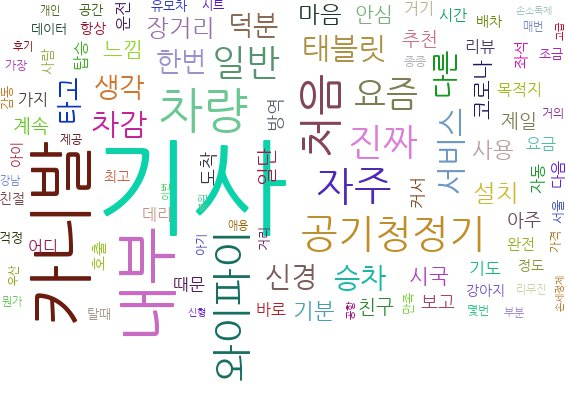

In [14]:
#워드크라우드 생성
pytagcloud.create_tag_image(tag_list, 'iM_high.jpg', size=(700, 400), fontname = 'NanumGothic', rectangular = False)
Image('/Users/michael/Desktop/appstore/iM_high.jpg')

In [15]:
#형태소 카운팅 (부정평가)
bow_vect = vect.fit_transform(low.REVIEW.tolist())
word_list = vect.get_feature_names()
count_list = bow_vect.toarray().sum(axis = 0)

In [16]:
#카운팅 데이터 데이터프레임 정리
word_count_dict = dict(zip(word_list, count_list))
df = pd.DataFrame(sorted(word_count_dict.items(), key = operator.itemgetter(1), reverse = True), columns = ['low_word', 'low_count'])
df

,low_word,low_count
0,기사,19
1,사용,12
2,서비스,10
3,카니발,9
4,서울,8
...,...,...
299,환영,1
300,홧병,1
301,회사,1
302,회원,1


In [17]:
#카운팅 데이터 파일 도출
df.to_csv('/Users/michael/Desktop/appstore/iM_low.csv')

In [18]:
#100개의 가장 흔한 데이터 도출
ranked_tags = Counter(word_count_dict).most_common(100)
tag_list = pytagcloud.make_tags(sorted(word_count_dict.items(), key = operator.itemgetter(1), reverse = True)[:100], maxsize = 100)

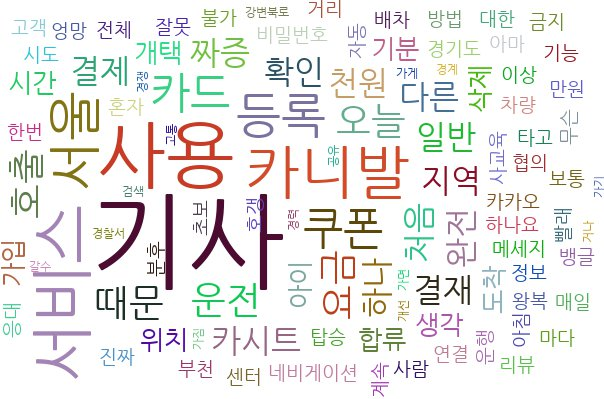

In [19]:
#워드크라우드 생성
pytagcloud.create_tag_image(tag_list, 'iM_low.jpg', size=(640, 400), fontname = 'NanumGothic', rectangular = False)
Image('/Users/michael/Desktop/appstore/iM_low.jpg')

In [20]:
#좋아요 많은 리뷰 데이터 분석
df = pd.read_csv('/Users/michael/Desktop/appstore/im_Crawling_data.csv')
df['RATE'] = df['STAR'].str[10:11]
df = df[['RATE', 'LIKE', 'REVIEW']]
df.head()

,RATE,LIKE,REVIEW
0,5,1.0,쿠폰 준다고 해서 처음 타봣어요 ㅎㅎ 차량이 일단 커서 엄청 좋구요 향기도 좋은 것...
1,5,1.0,자주타는데 일반 택시랑 가격차이도 많이 안나는데 쾌적하고 기사님들 친절하셔서 너무 ...
2,5,3.0,"아가와 함께 이동할 때 최고입니다. 우선 차량이 깨끗하고, 유모차와 아가짐을 실을 ..."
3,5,1.0,너무나편한택시이구 너무나빨리오고 향기도좋습니다 그래서 다른택시들보다 편한느낌드렸습니...
4,5,2.0,ㅋㅋㅇ택시만 이용하다가 아이엠택시 첫이용하고 띠용..! 정말 신세계입니다~^^ 아무...


In [21]:
#좋아요 상위 10%의 리뷰 데이터 정리
df2 = df.sort_values(['LIKE'], ascending = False)
liked = df2.reset_index(drop = True)
size = round(df2.shape[0]*0.1)
df_like = liked.head(size)
df_like.tail()

,RATE,LIKE,REVIEW
50,1,24.0,종암경찰서 앞에서 석관동 의릉까지 길이 막혀도 6~7천원 이죠?? 이상하게 기사님이...
51,5,24.0,상냥하고 정직하신 기사님! 합리적인 요금! 개인적으로는 ㅋㅋㅇ택시 보다 훨씬 좋네요...
52,1,23.0,콜택시 였으면 1분 기다릴걸 10분 넘게 기다렸는데 그건 차량이 많지 않겠거니 그렇...
53,5,23.0,김포공항까지 편하게 다녀왔어요. 엄청 친절하신 기사님덕에 후기도 남겨봅니다^^ 미터...
54,5,23.0,타다플러스 이용하다가 서비스가 점점엉망되서 실망하던중 우연히 알게되서 이용하게 되었...


In [22]:
#형태소 카운팅 (좋아요 상위 10%)
bow_vect = vect.fit_transform(df_like.REVIEW.tolist())
word_list = vect.get_feature_names()
count_list = bow_vect.toarray().sum(axis = 0)

#카운팅 데이터 데이터프레임 정리
word_count_dict = dict(zip(word_list, count_list))
df = pd.DataFrame(sorted(word_count_dict.items(), key = operator.itemgetter(1), reverse = True), columns = ['liked_word', 'liked_count'])
df

,liked_word,liked_count
0,기사,35
1,카니발,16
2,요금,11
3,차량,11
4,내부,10
...,...,...
421,형태,1
422,혹시,1
423,확대,1
424,홧병,1


In [23]:
#카운팅 데이터 파일 도출
df.to_csv('/Users/michael/Desktop/appstore/iM_liked.csv')

In [24]:
#100개의 가장 흔한 데이터 도출
ranked_tags = Counter(word_count_dict).most_common(100)
tag_list = pytagcloud.make_tags(sorted(word_count_dict.items(), key = operator.itemgetter(1), reverse = True)[:100], maxsize = 100)

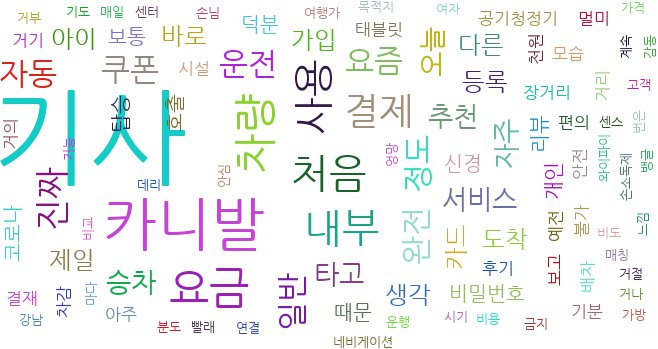

In [25]:
#워드크라우드 생성
pytagcloud.create_tag_image(tag_list, 'iM_liked.jpg', size=(680, 350), fontname = 'NanumGothic', rectangular = False)
Image('/Users/michael/Desktop/appstore/iM_liked.jpg')